In [6]:
from qiskit.circuit.library import TwoLocal
from qiskit_qulacs.qulacs_estimator import QulacsEstimator
from qiskit.quantum_info import SparsePauliOp
import numpy as np

# Create a two-local quantum circuit with 3 qubits
qc = TwoLocal(3, ['ry', 'rz', 'rx'], ['cx'],
              'linear',
              1,
              insert_barriers=False).decompose()

# Generate random parameter values for the circuit
params = np.random.rand(qc.num_parameters)

# Create a SparsePauliOp observable
obs = SparsePauliOp.from_list([('Z' * qc.num_qubits, 0.5)])

# Initialize QulacsEstimator
qulacs_estimator = QulacsEstimator()

# Run the estimation job with the circuit, observable, and parameters
job = qulacs_estimator.run(qc, obs, params)

# Get the result of the job
result = job.result()

# Retrieve the expectation value from the result
expectation_value = result.values[0]

# Print the expectation value
print("Expectation value:", expectation_value)

Expectation value: 0.18847435726773382


In [8]:
from qiskit_qulacs.qulacs_estimator_gradient import QulacsEstimatorGradient

qulacs_grad = QulacsEstimatorGradient(qulacs_estimator)

job = qulacs_grad.run(
    [qc],
    [obs],
    [params],
)

result = job.result()
gradient = result.gradients[0]

print("Gradient:", gradient)

Gradient: [-0.2126241  -0.04796353 -0.05154829  0.02681518  0.00488929  0.00552927
  0.06642367  0.03351243 -0.18262988 -0.08019862  0.00288364 -0.09999378
  0.04836719  0.00421099  0.13197252  0.03088525 -0.0735847   0.00764089]


In [1]:
import qulacs.gate as gate
from qiskit import extensions as ex
from qiskit.quantum_info import Statevector

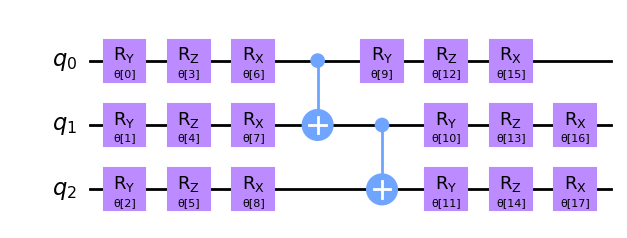

In [2]:
from qiskit.circuit.library import TwoLocal
from qiskit.circuit import Parameter, ParameterVector
import numpy as np

pqc = TwoLocal(3, ['ry','rz', 'rx'], ['cx'], 'linear', 1, insert_barriers=False).decompose()
a = ParameterVector('x', 3)
# qc.u(a[0], a[1], a[2], 0)
# qc.rx(1.2, 1)
pqc.draw('mpl')

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


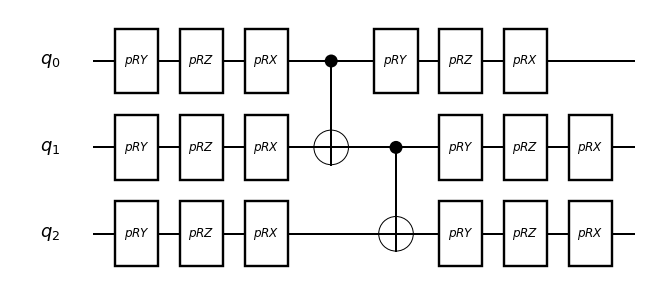

In [3]:
from qulacsvis import circuit_drawer
import matplotlib.pyplot as plt
from qiskit_qulacs.adapter import convert_qiskit_to_qulacs_circuit

params = np.arange(pqc.num_parameters) + 1
print(params)
# params = np.random.randn(pqc.num_parameters)
circuit_builder, parameter_mapping = convert_qiskit_to_qulacs_circuit(pqc)
circuit = circuit_builder(params)
circuit_drawer(circuit, 'mpl')

In [4]:
sv = Statevector.from_instruction(pqc.bind_parameters(params)).data
sv

array([-0.03625217-0.26514919j,  0.48242007-0.42497593j,
        0.07908794-0.02802145j,  0.01873977+0.08989009j,
       -0.0623662 -0.05371113j,  0.0362955 +0.07964352j,
       -0.5526936 +0.40272276j,  0.05989487+0.11789147j])

In [243]:
from qiskit_qulacs import QulacsProvider

qulacs_sv = QulacsProvider().get_backend('statevector_simulator')
qulacs_sv

QulacsBackend[statevector_simulator]

In [244]:
vec = qulacs_sv.run(pqc.bind_parameters(params)).result().get_statevector()
vec

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


array([-0.03625217-0.26514919j,  0.48242007-0.42497593j,
        0.07908794-0.02802145j,  0.01873977+0.08989009j,
       -0.0623662 -0.05371113j,  0.0362955 +0.07964352j,
       -0.5526936 +0.40272276j,  0.05989487+0.11789147j])

In [245]:
np.allclose(sv, vec)

True

In [246]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_qulacs.adapter import convert_sparse_pauliop_to_qulacs_observable

sparse_pauliop = SparsePauliOp.from_list([('Z'*pqc.num_qubits, 0.5)])
qulacs_observable = convert_sparse_pauliop_to_qulacs_observable(sparse_pauliop)

print(qulacs_observable)

0.5 Z 0 Z 1 Z 2


In [247]:
from qiskit.primitives import Estimator, BackendEstimator

Estimator().run([pqc], [sparse_pauliop], [params]).result().values

array([0.05536601])

In [248]:
from qiskit_qulacs.qulacs_estimator import QulacsEstimator

QulacsEstimator().run([pqc], [sparse_pauliop], [params]).result().values

[[0], [3], [6], [1], [4], [7], [], [9], [12], [15], [2], [5], [8], [], [10], [13], [16], [11], [14], [17]]


array([0.05536601])

In [269]:
from __future__ import annotations

import sys
from collections.abc import Sequence

import numpy as np

from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.opflow import PauliSumOp
from qiskit.primitives import BaseEstimator
from qiskit.providers import Options
from qiskit.quantum_info.operators.base_operator import BaseOperator

from qiskit.algorithms.gradients import BaseEstimatorGradient
from qiskit.algorithms.gradients.estimator_gradient_result import EstimatorGradientResult
from qiskit_qulacs.adapter import convert_qiskit_to_qulacs_circuit, convert_sparse_pauliop_to_qulacs_observable
from qiskit.algorithms.exceptions import AlgorithmError

if sys.version_info >= (3, 8):
    from typing import Literal
else:
    from typing_extensions import Literal

class QulacsEstimatorGradient(BaseEstimatorGradient):
    def __init__(
        self,
        estimator: BaseEstimator,
        options: Options | None = None,
    ):
        super().__init__(estimator, options)

    def _run(
        self,
        circuits: Sequence[QuantumCircuit],
        observables: Sequence[BaseOperator | PauliSumOp],
        parameter_values: Sequence[Sequence[float]],
        parameters: Sequence[Sequence[Parameter]],
        **options,
    ) -> EstimatorGradientResult:
        """Compute the estimator gradients on the given circuits."""

        gradients = []
        for circuit, observable, parameter_values_, parameters_ in zip(
            circuits, observables, parameter_values, parameters
        ):
            qulacs_circuit, metadata = convert_qiskit_to_qulacs_circuit(circuit)
            parameter_mapping = metadata['paramater_mapping']
            print(parameter_mapping)
            gradient = np.negative(qulacs_circuit(parameter_values_).backprop(convert_sparse_pauliop_to_qulacs_observable(observable)))
            print()
            print(np.round(gradient*1000))
            
#             res = np.zeros(gradient.shape)
#             mapping_indices = np.arange(len(parameter_mapping))
#             res[parameter_mapping] = gradient[mapping_indices]
#             gradient = res

            mapping_indices = np.arange(len(parameter_mapping))
            gradient[parameter_mapping] = gradient[mapping_indices]
        
#             mapping_indices = np.arange(len(parameter_mapping))
#             gradient[:] = gradient[mapping_indices]

#             res = np.zeros(gradient.shape)
            
#             for i, val in enumerate(parameter_mapping):
#                 res[val] = gradient[i]
            
#             gradient = res
            # Indices of parameters to be differentiated
            indices = [circuit.parameters.data.index(p) for p in parameters_]
            gradients.append(gradient[indices])

        opt = self._get_local_options(options)
        return EstimatorGradientResult(gradients=gradients, metadata={}, options=opt)


In [270]:
from qiskit.algorithms.gradients import ReverseEstimatorGradient

qiskit_grad = ReverseEstimatorGradient()
res = qiskit_grad.run([pqc],
                    [sparse_pauliop],
                    [params],
                    ).result().gradients[0]
np.round(res*1000)

array([-360.,  -39.,  -21., -164.,  181.,   -2., -342.,  -14.,  -20.,
         81.,  -24.,  107.,  -34.,  -31.,  -75.,   49.,   25.,  -88.])

In [271]:
# from qiskit_qulacs.qulacs_estimator_gradient import QulacsEstimatorGradient

qulacs_grad = QulacsEstimatorGradient(Estimator())
out = qulacs_grad.run([pqc],
                    [sparse_pauliop],
                    [params],
                    ).result().gradients[0]
np.round(out*1000)

[[0], [3], [6], [1], [4], [7], [], [9], [12], [15], [2], [5], [8], [], [10], [13], [16], [11], [14], [17]]
[0, 3, 6, 1, 4, 7, 9, 12, 15, 2, 5, 8, 10, 13, 16, 11, 14, 17]

[-360. -164. -342.  -39.  181.  -14.   81.  -34.   49.  -21.   -2.  -20.
  -24.  -31.   25.  107.  -75.  -88.]


array([-360.,  -39.,  -21., -164.,  181.,   -2., -342.,  -14.,  -20.,
         81.,  -24.,  107.,  -34.,  -31.,  -75.,   49.,   25.,  -88.])

In [272]:
np.allclose(res, out)

True

In [273]:
res = qiskit_grad.run([pqc],
                    [sparse_pauliop],
                    [params],
                    [pqc.parameters[:2]]
                    ).result().gradients[0]
res

array([-0.36030734, -0.0391479 ])

In [274]:
out = qulacs_grad.run([pqc],
                    [sparse_pauliop],
                    [params],
                    [pqc.parameters[:2]]
                    ).result().gradients[0]
out

[[0], [3], [6], [1], [4], [7], [], [9], [12], [15], [2], [5], [8], [], [10], [13], [16], [11], [14], [17]]
[0, 3, 6, 1, 4, 7, 9, 12, 15, 2, 5, 8, 10, 13, 16, 11, 14, 17]

[-360. -164. -342.  -39.  181.  -14.   81.  -34.   49.  -21.   -2.  -20.
  -24.  -31.   25.  107.  -75.  -88.]


array([-0.36030734, -0.0391479 ])

In [275]:
np.allclose(res, out)

True

In [18]:
# from qulacs import QuantumCircuit, QuantumState, Observable

# observable = Observable(n)
# observable.add_operator(1., ' '.join([f'Z {i}' for i in range(n)]))
# np.array(circuit.backprop(observable))

In [19]:
import qiskit_qulacs

In [20]:
# dir(qiskit_qulacs)

In [21]:
from qiskit_qulacs import QulacsProvider

In [22]:
provider = QulacsProvider()
backends = provider.backends()

qulacs_sv = provider.get_backend("statevector_simulator")

In [23]:
backends

[QulacsBackend[statevector_simulator]]

In [24]:
# BackendEstimator(qulacs_sv).run(pqc, ham, params).result()

In [25]:
# from qiskit.algorithms.gradients import FiniteDiffEstimatorGradient

# fdg = FiniteDiffEstimatorGradient(BackendEstimator(qulacs_sv), 1e-1)
# fdg.run([pqc], [ham], [params]).result()

In [26]:
qc = QkQuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw()

NameError: name 'QkQuantumCircuit' is not defined

In [ ]:
qulacs_sv.run(qc).result().get_statevector()

In [ ]:
from qulacs import QuantumCircuitSimulator
from qiskit.transpiler import InstructionProperties, Target
from qiskit.circuit import Parameter

QISKIT_GATE_TO_QULACS_GATE_MAPPING = {
    # native PennyLane operations also native to qiskit
    "X": ex.XGate(),
    "Y": ex.YGate(),
    "Z": ex.ZGate(),
    "H": ex.HGate(),
    "CNOT": ex.CXGate(),
    "CZ": ex.CZGate(),
    "SWAP": ex.SwapGate(),
    "FREDKIN": ex.CSwapGate(),
    "RX": ex.RXGate(Parameter("theta")),
    "RY": ex.RYGate(Parameter("theta")),
    "RZ": ex.RZGate(Parameter("theta")),
    "Identity": ex.IGate(),
    "TOFFOLI": ex.CCXGate(),
    "U1": ex.U1Gate(Parameter("theta")),
    "U2": ex.U2Gate(Parameter("theta"), Parameter("lam")),
    "U3": ex.U3Gate(Parameter("theta"), Parameter("phi"), Parameter("lam")),
    "U3": ex.UGate(Parameter("theta"), Parameter("phi"), Parameter("lam")),
    "S": ex.SGate(),
    "Sdag": ex.SdgGate(),
    "T": ex.TGate(),
    "Tdag": ex.TdgGate(),
    "sqrtX": ex.SXGate(),
    "sqrtXdag": ex.SXdgGate(),
}

def local_simulator_to_target(simulator: QuantumCircuitSimulator) -> Target:

    target = Target()

    instructions = [
        inst
        for inst in QISKIT_GATE_TO_QULACS_GATE_MAPPING.values()
        if inst is not None
    ]
#     properties = simulator.properties
#     paradigm: GateModelSimulatorParadigmProperties = properties.paradigm
    
    num_qubits = 26
        
    # add measurement instruction
#     target.add_instruction(Measure(), {(i,): None for i in range(paradigm.qubitCount)})
  
    for instruction in instructions:
        instruction_props: Optional[
            Dict[Union[Tuple[int], Tuple[int, int]], Optional[InstructionProperties]]
        ] = {}
                    
        if instruction.num_qubits == 1:
            
            for i in range(num_qubits):
                instruction_props[(i,)] = None
            target.add_instruction(instruction, instruction_props)
        elif instruction.num_qubits == 2:
            for src in range(num_qubits):
                for dst in range(num_qubits):
                    if src != dst:
                        instruction_props[(src, dst)] = None
                        instruction_props[(dst, src)] = None
            target.add_instruction(instruction, instruction_props)

    return target

local_simulator_to_target(sim)

In [ ]:
dir(sim)

In [ ]:
BackendEstimator(backend=qulacs_sv).run(pqc, ham, params).result().values

In [ ]:
from qiskit.algorithms import VQE
from qiskit.opflow import (
    I,
    X,
    Z,
)
from qiskit import transpile, QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance

from braket.aws import AwsQuantumJob

import qiskit_braket_provider
from qiskit_braket_provider import AWSBraketProvider, BraketLocalBackend
from braket.devices import LocalSimulator
import json

In [ ]:
local_simulator = LocalSimulator()
local_simulator

In [ ]:
local_simulator.properties.paradigm

In [ ]:
# dir(qiskit_braket_provider)

In [ ]:
# from qiskit_braket_provider.providers.adapter import  convert_qiskit_to_braket_circuits

In [ ]:
# list(convert_qiskit_to_braket_circuits([pqc]))[0]

In [ ]:
# job = local_simulator.run(pqc,shots=100)
# job

In [ ]:
# plot_histogram(job.result().get_counts())

In [286]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_qulacs.adapter import convert_qiskit_to_qulacs_circuit
from qulacs import QuantumState

input_state_vector = np.array([np.sqrt(3) / 2, np.sqrt(2) * complex(1, 1) / 4])

qiskit_circuit = QuantumCircuit(1)
qiskit_circuit.prepare_state(input_state_vector, 0)

print(qiskit_circuit.decompose().decompose().decompose())

qulacs_circuit, metadata = convert_qiskit_to_qulacs_circuit(qiskit_circuit)

state = QuantumState(qiskit_circuit.num_qubits)
qulacs_circuit().update_quantum_state(state)
output_state_vector = state.get_vector()

print(input_state_vector, output_state_vector)

assert(np.allclose(output_state_vector, input_state_vector) == True)

global phase: π/8
   ┌─────────┐┌─────────┐
q: ┤ Ry(π/3) ├┤ Rz(π/4) ├
   └─────────┘└─────────┘
"to_matrix not defined for this <class 'qiskit.circuit.library.data_preparation.state_preparation.StatePreparation'>"
[]
[0.8660254 +0.j         0.35355339+0.35355339j] [1.+0.j 0.+0.j]


AssertionError: 

In [287]:
## 